# Overview and Setup

The goal of this post is to do some data cleaning on the Oxford-IIIT Pets dataset, an image classification dataset with photos of cats and dogs.
We'll get our results using image embeddings from the body of a pre-trained ResNet model, some basic machine learning and image processing techniques, and a full ResNet model fine-tuned on the dataset using fastai.
We'll use fastai's version of the Pets dataset and take advantage of some convenience functions from the [fastai](https://docs.fast.ai/) and [fastcore](https://fastcore.fast.ai/) libraries.

In [1]:
#| echo: false

# these imports are only used to make the table of package versions
import fastai
import fastcore
import scipy
import sys
from IPython.display import Markdown

In [2]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torch
import torchvision
import torch.nn.functional as F

import fastcore.all as fc

The list of Python packages and specific versions used to make this post are in the table below.

In [3]:
#| echo: false

package_list = [
    ('python',        sys.version.split()[0]),
    ('scipy',         scipy.__version__),
    ('fastai',        fastai.__version__),
    ('pytorch',       torch.__version__),
    ('fastcore',      fastcore.__version__),
    ('torchvision',   torchvision.__version__),
    ('opencv-python', cv2.__version__),
]

Markdown(
    pd.DataFrame(package_list, columns=['Package', 'Version'])
      .to_markdown(index=False)
)

| Package       | Version      |
|:--------------|:-------------|
| python        | 3.9.16       |
| scipy         | 1.9.2        |
| fastai        | 2.7.13       |
| pytorch       | 2.1.2+cu121  |
| fastcore      | 1.5.29       |
| torchvision   | 0.16.2+cu121 |
| opencv-python | 4.9.0        |

# Get the Data

We'll download the Pets dataset using fastai's `untar_data` function, which returns a `Path` object to the download directory.

In [4]:
from fastai.vision.all import untar_data, URLs

path = untar_data(URLs.PETS)
path

Path('/root/.fastai/data/oxford-iiit-pet')

Let's look at how the directory is organized...

In [5]:
os.listdir(path)

['images', 'annotations']

... and at part of the images folder.

In [6]:
random.seed(42)
random.sample(os.listdir(path/'images'), k=5)

['basset_hound_98.jpg',
 'wheaten_terrier_181.jpg',
 'pomeranian_174.jpg',
 'Bengal_191.jpg',
 'miniature_pinscher_53.jpg']

The fastai library has a function, `get_image_files`, that collects all of the image files in a directory.
It returns an `L`, fastcore's drop-in replacement for python `list`s with added conveniences.

In [7]:
from fastai.vision.all import get_image_files

pets_dataset = get_image_files(path/'images').sorted()

::: {.column-margin}
`L` has a built-in `sorted` method
:::

Now let's take a quick look at some sample images.
Images of dogs have filenames that start with a lowercase letter, while images of cats have filenames that start with an uppercase letter. 
<!-- For later use, we'll define a convenience function to display lists of images. -->

In [8]:
#| code-fold: true
#| code-summary: "Code for `show_image_list`"

import math
from itertools import zip_longest
from fastai.vision.all import load_image

def show_image_list(images, max_per_col=4,
                    title_option='filename',
                    col_width=12, row_height=3):
    ncols = min(max_per_col, len(images))
    nrows = math.ceil(len(images) / ncols)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            figsize=(col_width, row_height*nrows))

    plot_data = fc.loop_first(zip_longest(images, axs.flat))
    for first, (img, ax) in plot_data:
        if img is not None:
            if isinstance(img, Path):
                ax.imshow(load_image(img, mode='RGB'))
                title_dict = {
                    'filename': img.stem,
                    'label_original': 'Original' if first else ''
                }
            # used when we look for blurry images
            elif isinstance(img, np.ndarray):
                ax.imshow(img, cmap='Grays')
                title_dict = {'filename': 'Laplacian'}
            ax.set(xticks=[], yticks=[])
            ax.set_title(title_dict[title_option], fontsize=9)
        # used in testing
        else:
            ax.axis('off')
    fig.tight_layout()
    plt.show()

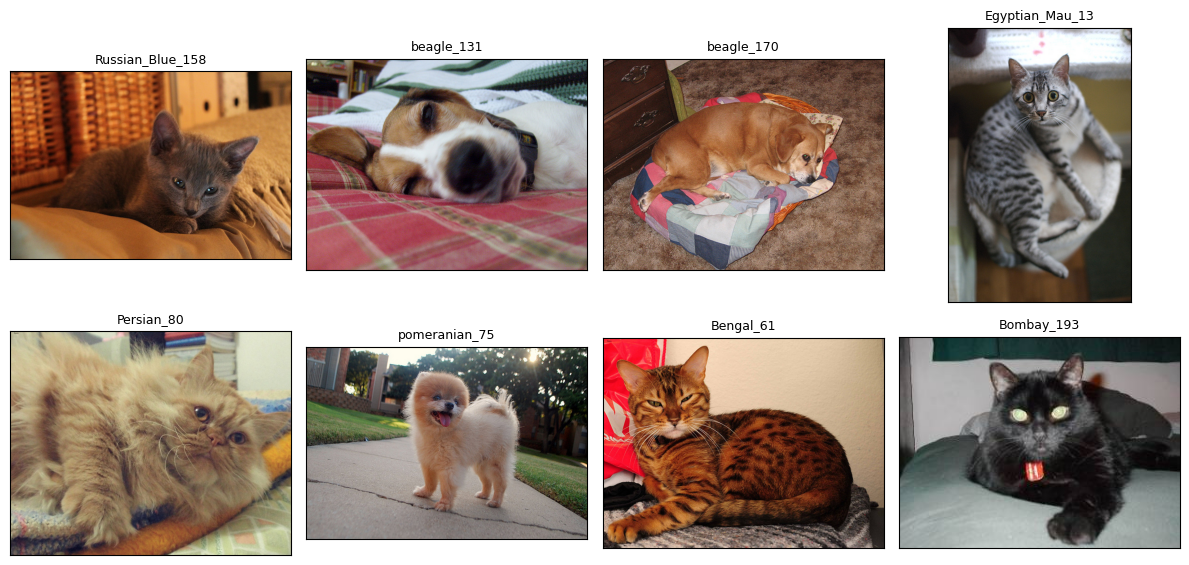

In [9]:
random.seed(8)
sample_imgs = random.sample(pets_dataset, k=8)
show_image_list(sample_imgs)

# Get the Embeddings

Now we'll get image embeddings using the body of a pre-trained ResNet50.
The fastai function `create_body` extracts the body of the ResNet from the full model.
The outputs of the body are reduced to 2048-dimensional vectors by taking the maximum over each output channel.

::: {.callout-important}
I'm intentionally *not* fine-tuning the model on the dataset when I want to use the embeddings directly.
I tried fine-tuning models on classification tasks (cats vs dogs and breeds) and then computing image embeddings, but it resulted in decreased performance on image similarity search and finding duplicate images, the tasks we'll use the embeddings for.

Fine-tuning on classifying cats vs dogs resulted in such a large drop in performance that the embeddings became useless;
fine-tuning on classifying breeds resulted in a smaller but still noticeable drop.
:::

In [10]:
from fastai.vision.all import create_body, load_image
from torch.utils.data import DataLoader


class PetsDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, tfms):
        self.imgs = imgs
        self.tfms = tfms
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_file = self.imgs[idx]
        img = load_image(img_file, mode='RGB')
        img = self.tfms(img)
        return img

def image_embeddings(imgs, model, batch_size, tfms, device):
    model_body = create_body(model).to(device)
    model_body.eval()

    @torch.inference_mode()
    def embed(x):
        emb = model_body(x).amax(dim=(-1, -2))
        return emb.to('cpu')
    
    pets_ds = PetsDataset(imgs, tfms)
    pets_dl = DataLoader(
        pets_ds, batch_size=batch_size, shuffle=False, num_workers=4
    )
    embs = torch.cat([embed(batch.to(device)) for batch in pets_dl])
    return embs

We'll use weights and the associated pre-processing transforms available from Torchvision.^[I tried out a few reasonably sized pre-trained models from torchvision, fastai, and timm, and the embeddings from this Torchvision ResNet50 model seemed to perform the best on image similarity search and finding duplicate images.]

In [11]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
model = torchvision.models.resnet50(weights=weights)
tfms = weights.transforms()
embeddings = image_embeddings(pets_dataset, model, 64, tfms, device)

# Identify Problem Images

We'll start our dataset cleaning process by finding duplicate and near-duplicate images.

In [12]:
images_to_remove = set()

## Image Similarity Search

Before we go any further, let's implement a basic image similarity search function over the dataset.
If our embeddings can't accomplish that task, then using them to look for duplicates will be a waste of time.
We'll measure how similar two images are using the cosine similarity distance between their embeddings.

In [13]:
def pairwise_cosine_similarities(embs, batch_size=8, device=device):
    embs = embs.to(device)
    num_embs = embs.shape[0]
    distances = torch.empty((num_embs, num_embs), device=device)
    for idx in range(0, num_embs, batch_size):
        s = slice(idx, min(idx+batch_size, num_embs))
        distances[s] = F.cosine_similarity(embs[None], embs[s, None], dim=-1)
    # don't match dataset entries with themselves
    distances.fill_diagonal_(-torch.inf)
    return distances.to('cpu')

distances = pairwise_cosine_similarities(embeddings)

Now let's look at some examples and see if our embeddings are worth anything.

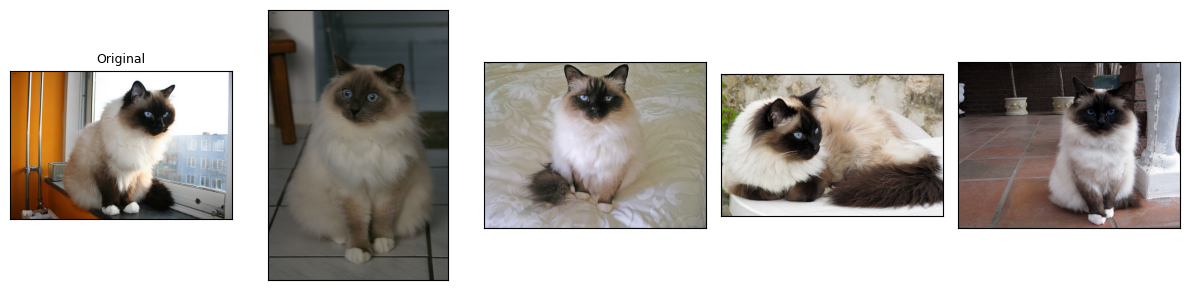

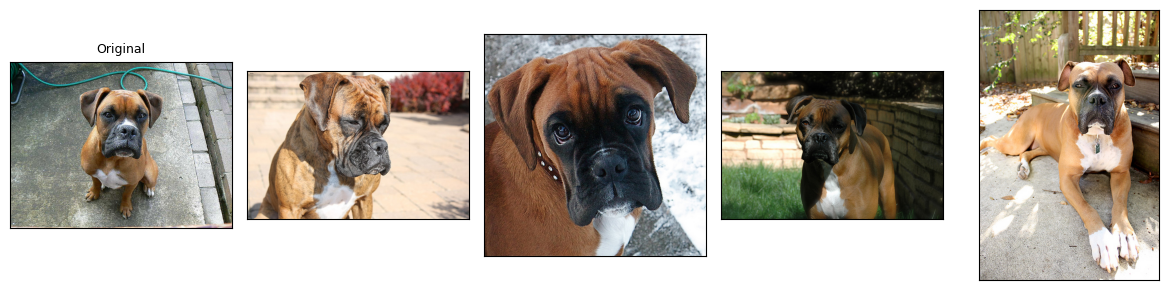

In [14]:
def show_k_closest(idx, dataset=pets_dataset, distances=distances, k=4):
    item_metrics = distances[idx]
    k_closest_idxs = item_metrics.argsort(descending=True)[:k]
    k_closest_imgs = dataset[k_closest_idxs]
    relevant_imgs = [dataset[idx]] + k_closest_imgs
    show_image_list(
        relevant_imgs,
        max_per_col=k+1,
        title_option='label_original',
    )

show_k_closest(500)
show_k_closest(3303)

::: {.column-margin}
`L` supports numpy-style indexing
:::

Looks good!

## Duplicate and Near-Duplicate Images

Now let's go ahead and find groups of similar images to hunt for duplicates.
We'll threshold the distances we computed earlier to get a boolean matrix, which we can view as the adjacency matrix of a graph whose vertices are the entries of the dataset.^[I chose the threshold of `0.85` to try to catch as many duplicate groups as I could while making sure that near-duplicate groups had only small changes between the images.]
The connected components of that graph with more than one vertex are our desired groups.

In [15]:
from scipy.sparse.csgraph import connected_components

def group_similar_images(distances, threshold, dataset=pets_dataset):
    graph = (distances > threshold).numpy()
    num_components, labels = connected_components(graph)
    components = fc.L(dataset[labels == i] for i in range(num_components))
    groups = components.filter(lambda o: len(o) > 1)
    return groups

groups = group_similar_images(distances, 0.85)

::: {.column-margin}
`L` has a built-in `filter` method.
:::

How many images did we find?

In [16]:
print(f'number of groups: {len(groups):3d}\n'
      f'number of images: {len(groups.concat())}')

number of groups:  92
number of images: 192


::: {.column-margin}
`L` has a built-in `concat` method that concatenates all of its elements into a new `L`
:::

We can check and see that the groups we found really are duplicates or near-duplicates. We'll only show a selection of the groups we found; the remaining ones are similar.

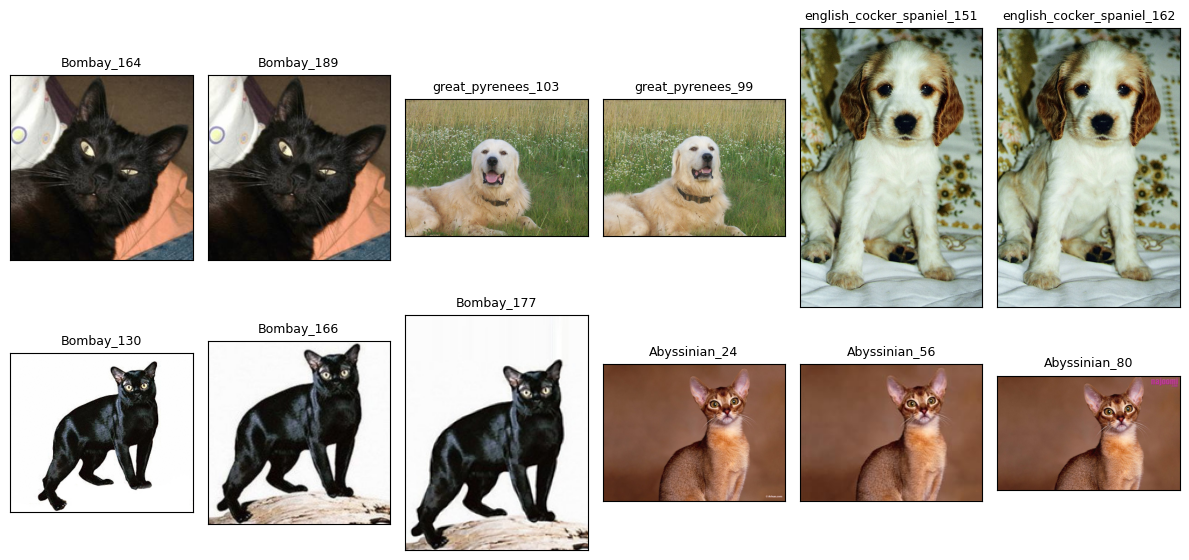

In [17]:
show_image_list(groups[20, 52, 44, 16, 2].concat(), max_per_col=6)

Let's update our list of images to remove all but one member from each group.

In [18]:
duplicate_images = set(fc.flatten(o[1:] for o in groups))
images_to_remove.update(duplicate_images)

::: {.column-margin}
as its name suggests, `fc.flatten` flattens its input, returning a generator
:::

## Bright and Dark Images

One way to measure the brightness of an image is to convert it to HLS (hue, lightness, and saturation) format.
OpenCV has a `cvtColor` function that does this transformation.
They compute lightness in the following way. For each pixel in an RGB image, with values $(r, g, b)$, we set $V_\text{max} = \max(r, g, b)$ and $V_\text{min} = \min(r, g, b)$;
then the lightness of that pixel is the average $(V_\text{max} + V_\text{min}) / 2$.^[I found that OpenCV's implementation was faster than using the formula directly.]

In [19]:
def brightness(img):
    img = np.asarray(load_image(img, mode='RGB'))
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return img_hls[..., 1].mean()

bright_vals = fc.parallel(brightness, pets_dataset, n_workers=4)

::: {.column-margin}
`fc.parallel` is a convenience multiprocessing function that maps a function passed as the first input over the second input in parallel
:::

We'll filter for bright images using a lower bound on the brightness and only show a few of the brightest images.^[I didn't find any problem images with a lower threshold either.]

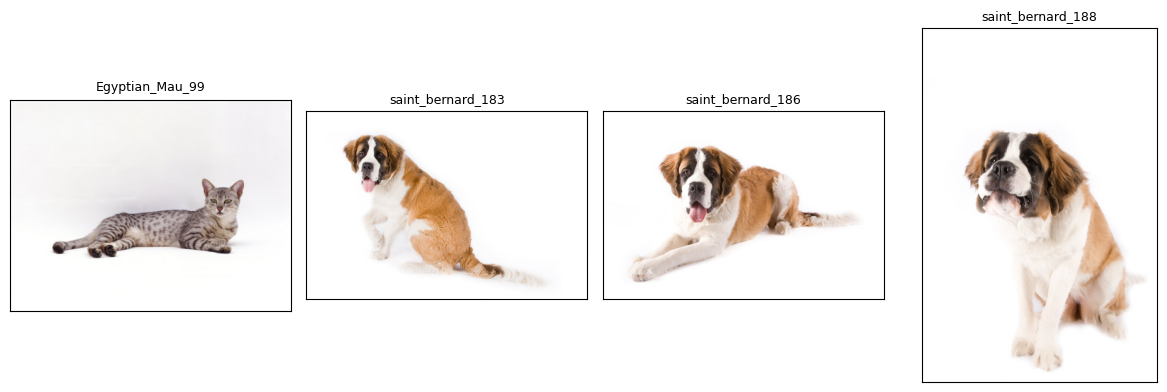

In [20]:
bright_images = pets_dataset[bright_vals.map(fc.gt(231))]
show_image_list(bright_images, row_height=4)

::: {.column-margin}
`fc.gt` is a fastcore function that, when passed one parameter, returns a curried version of `operator.gt`
:::

These images are also all clearly identifiable, so we'll keep them too.

We can also filter for dark images using an upper bound on the brightness.
Again, we'll only show a few of the darkest images.

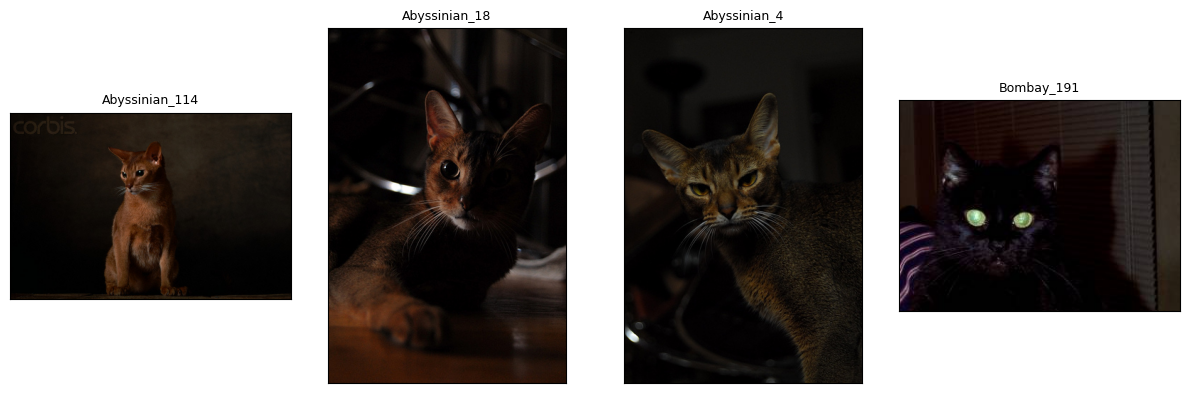

In [21]:
dark_images = pets_dataset[bright_vals.map(fc.lt(25))]
show_image_list(dark_images, row_height=4)

::: {.column-margin}
`fc.lt` is the "less than" analogue of the function `fc.gt` above
:::

These images are all clearly identifiable, so we won't remove any of them.

## Outliers

We'll look for potential outliers by first projecting our embeddings to a 50-dimensional space with principal component analysis and then using a local outlier factor model.^[Of the outlier detection methods I tried, this was the one that most easily found the problem image below.]
The value for `contamination` is set to a low value here to show only a few images.^[I didn't find any additional problem images with higher values for `contamination`.]

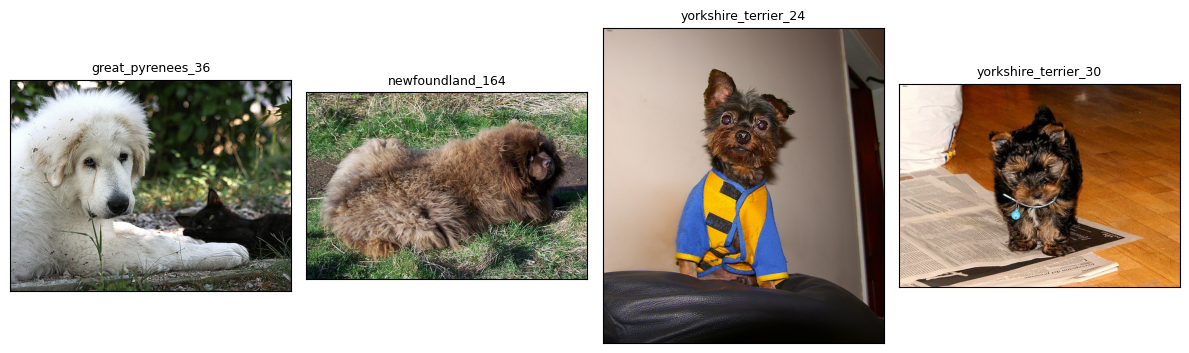

In [22]:
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=50, svd_solver='full')
clf = LocalOutlierFactor(
    n_neighbors=4, metric='cosine', n_jobs=4, contamination=0.0005
)
outlier_preds = make_pipeline(pca, clf).fit_predict(embeddings.numpy())
outlier_candidates = pets_dataset[outlier_preds == -1]
show_image_list(outlier_candidates, row_height=4)

One of these images looks like a problem: `great_pyrenees_36` contains both a cat and a dog, so we should remove it from the dataset.

In [23]:
images_to_remove.add(outlier_candidates[0])

## Blurry Images

We'll measure blurriness using the squared Euclidean norm of the image Laplacian. A sharp image tends to have many distinct edges and boundaries in it, and the image Laplacian detects those features.

In [24]:
def compute_laplacian(img):
    img = np.asarray(load_image(img, mode='L'))
    return cv2.Laplacian(img, cv2.CV_64F, ksize=5)

The way the Laplacian detects blurry images is most clearly seen through examples. We'll start with a relatively sharp image...

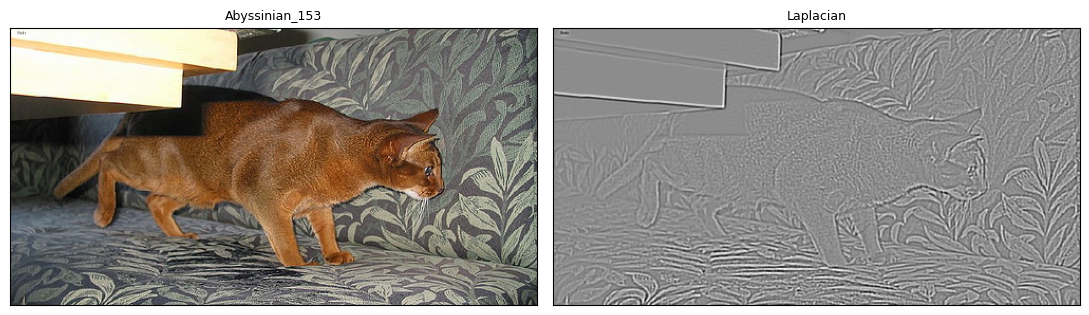

In [25]:
sharp_img = pets_dataset[59]
sharp_laplacian = compute_laplacian(sharp_img)
show_image_list([sharp_img, sharp_laplacian], col_width=11, row_height=6)

... and contrast that with a relatively blurry image.

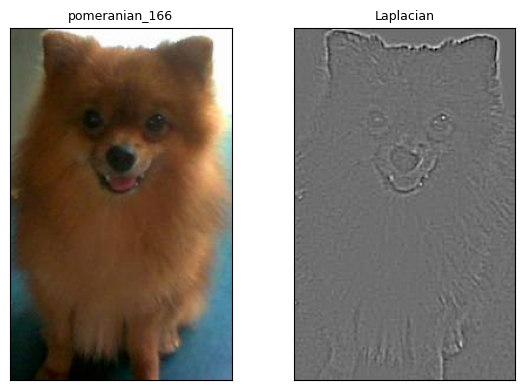

In [26]:
blurry_img = pets_dataset[5674]
blurry_laplacian = compute_laplacian(blurry_img)
show_image_list([blurry_img, blurry_laplacian], col_width=6, row_height=4)

Sharp images tend to have a Laplacian with a greater squared norm than blurry images.
We'll just compute it for each image and take those with the lowest values as our candidate blurry images.
I'll only show a few of the images whose Laplaicans have the smallest squared norms.^[I didn't find any problem images with higher threshold values.]

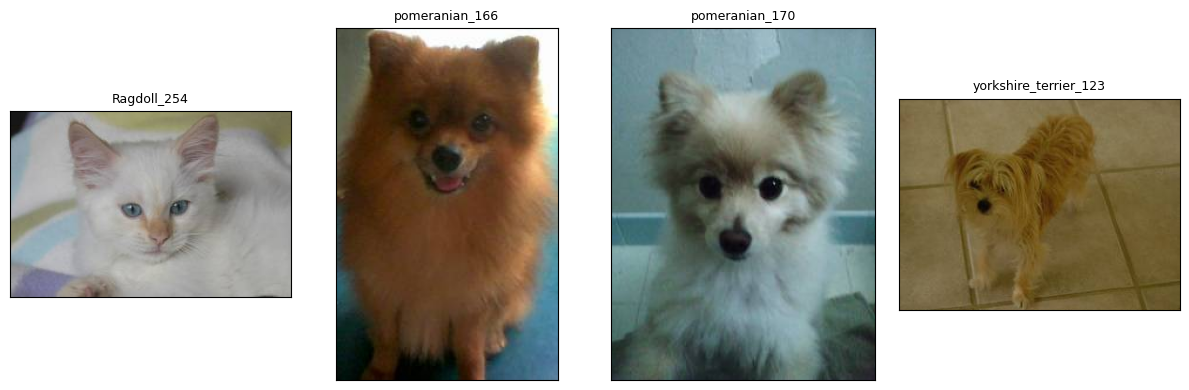

In [27]:
def laplacian_norm_squared(img):
    laplacian = compute_laplacian(img)
    return (laplacian**2).sum()

squared_norms = fc.parallel(laplacian_norm_squared, pets_dataset, n_workers=4)
threshold = np.quantile(squared_norms, q=0.0005)
blurry_candidates = pets_dataset[squared_norms.map(fc.lt(threshold))]
show_image_list(blurry_candidates, max_per_col=4, row_height=4)

::: {.column-margin}
`L` has a built-in `map` method
:::

Each of these images is identifiable, so we'll keep them all.

## Fine-Tune a Model

Finally, we'll use fastai to quickly fine-tune a breed classification model on the Pets dataset and examine the images with the greatest losses to check for any other issues.
We'll use fastai's `DataBlock` API to organize our data into a `DataLoaders` and the `vision_learner` convenience function to create a trainer that we'll use to fine-tune a pre-trained ResNet50 model.^[We're using fastai's ResNet50 pre-trained weights now since they fine-tuned more easily and to a higher accuracy than the Torchvision weights we used earlier.]
One of fastai's best features is its learning rate finder, which, as the name suggests, helps us find an advantageous learning rate.

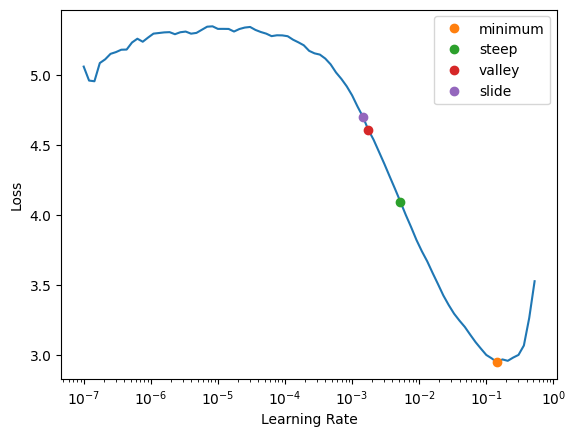

In [28]:
import fastai.vision.all as fv

def get_breed(filename):
    return '_'.join(filename.stem.split('_')[:-1])

dblock = fv.DataBlock(
    blocks=(fv.ImageBlock, fv.CategoryBlock),
    get_items=fc.noop,
    get_y=get_breed,
    item_tfms=fv.Resize(460),
    batch_tfms=[*fv.aug_transforms(size=224, min_scale=0.75),
                fv.Normalize.from_stats(*fv.imagenet_stats)],
)
dls = dblock.dataloaders(pets_dataset)
learn = fv.vision_learner(dls, fv.resnet50, metrics=fv.accuracy)
lrs = learn.lr_find(suggest_funcs=(fv.minimum, fv.steep, fv.valley, fv.slide))

It looks like the loss is decreasing most quickly at the point marked `steep`, so we'll use that learning rate.
We'll use the `Learner`'s `fine_tune` method to first freeze the weights in the model's body and train for one epoch, then unfreeze everything and train for five epochs.

In [29]:
learn.fine_tune(5, lrs.steep)

We can use fastai's `Interpretation` class to look at the images where the outputs from the model have the greatest losses.

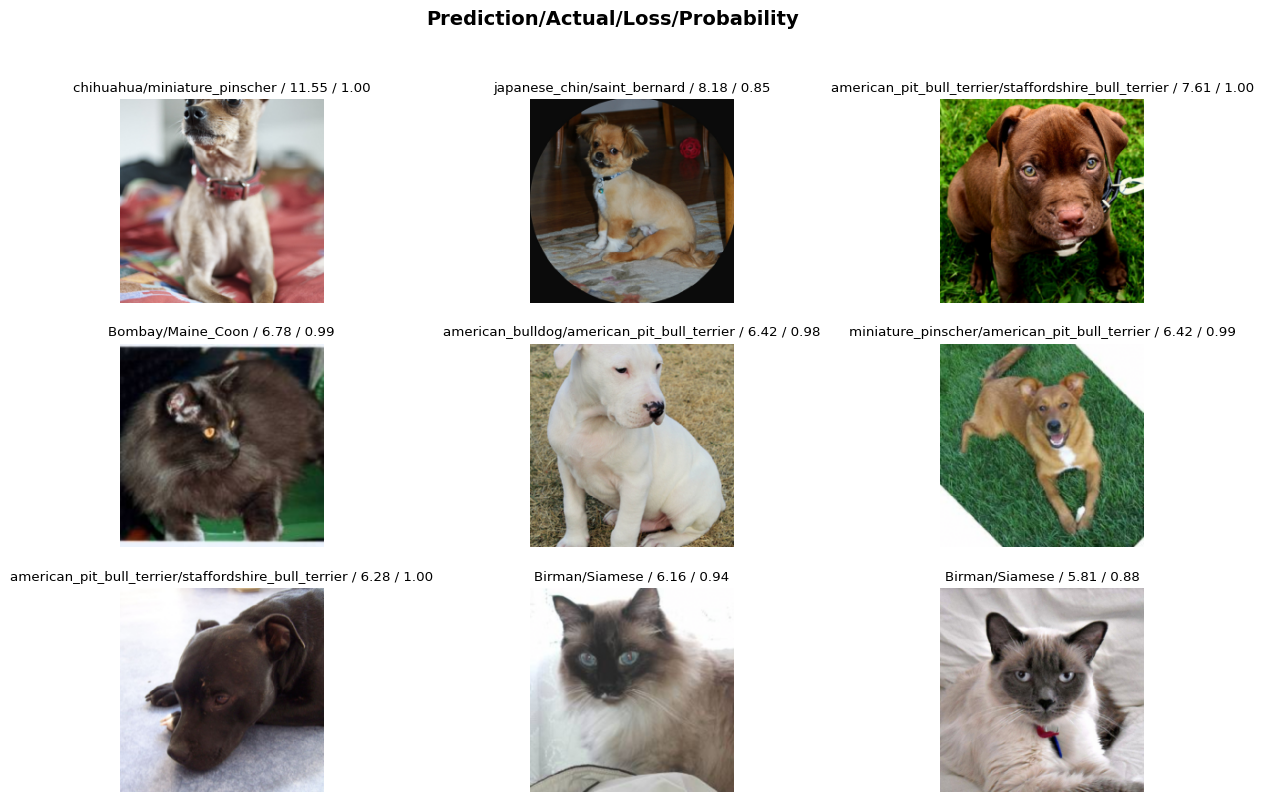

In [30]:
plt.rcParams.update({'font.size': 8})
interp = fv.Interpretation.from_learner(learn)
interp.plot_top_losses(k=9, nrows=3, figsize=(15, 9))

There don't seem to be any issues with the images themselves, so we won't remove anything from the dataset.

# Remove Problem Images

Finally, we'll remove the images we identified in our analysis and save the cleaned dataset to a CSV file for future use.

In [31]:
cleaned_pets = pets_dataset.filter(lambda o: o not in images_to_remove)
pd.DataFrame({'images': cleaned_pets}).to_csv('cleaned_pets.csv', index=False)